# Bootstrapping and Permutations

## Possible tests

* Bootstrapping effect sizes: *Given a treatment group A and control group B, what is the effect of the treatment on an outcome Y?*
* Permutation test: *Given a treatment group A and control group B, can we reject H0 that the two distributions of X are identical?*

## Bootstrapping effect sizes

Estimate the % change in the average between groups.

Given an input table with three fields, (id, groupid, value), and a number of bootstrap samples (nbootstraps), return a (nbootstraps length) vector of bootstrapped effect size estimates.

### Part 1: Generate fake data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon
import seaborn as sns
sns.set()

In [2]:
#sample size for each group
n1 = 100000
n2 = 10000
n = n1 + n2

In [25]:
# make fake data
# note: group2 should be 5 pp greater than group1 (2.1 vs 2.0)
input_data = pd.DataFrame(
    {'groupid': np.concatenate((np.repeat('g1', n1),
                                np.repeat('g2', n2))),
     'x': np.concatenate((expon.rvs(scale=.21, size=n1),
                          expon.rvs(scale=.20, size=n2)))}, index = range(1, n+1)
)

In [280]:
input_data.head()

,groupid,x
1,g1,0.036281
2,g1,0.149043
3,g1,0.008034
4,g1,0.001034
5,g1,0.292064


In [26]:
# split into two groups
g1 = input_data['groupid'] == 'g1'
g2 = input_data['groupid'] == 'g2'

In [27]:
# actual sample means
m1 = input_data.loc[g1, 'x'].mean()
m2 = input_data.loc[g2, 'x'].mean()

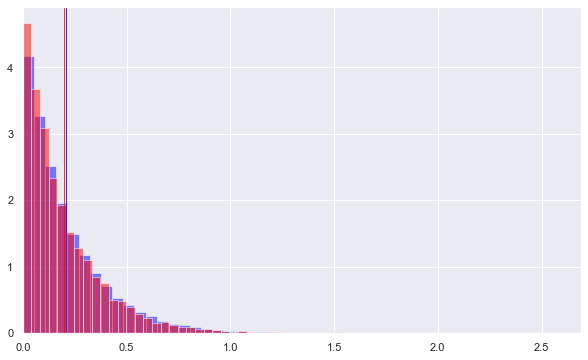

In [283]:
# plot the raw data
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x=input_data.loc[g1, 'x'], color=(0,0,1,.5), bins=50, density=True, alpha=0.5)
ax.hist(x=input_data.loc[g2, 'x'], color=(1,0,0,.5), bins=50, density=True, alpha=0.5)
ax.set_xlim((0, input_data['x'].max()))
#annotate the means
ax.axvline(input_data.loc[g1, 'x'].mean(), color="blue", linewidth=0.8)
ax.axvline(input_data.loc[g2, 'x'].mean(), color="red", linewidth=0.8);

### Part 2: Generate bootstrapped samples

For each data point i, draw `nbootstraps = 800` draws from a Poisson distribution with expectation 1

In [274]:
nbootstraps = 800
#draw bootstrapped samples
samplecounts = np.random.poisson(1, size=nbootstraps*n)

In [275]:
samplecounts = samplecounts.reshape((n,-1))

For example, the first data point gets assigned this many times in each of the 800 samples:

In [101]:
samplecounts[0,:]

array([1, 0, 1, 1, 1, 0, 1, 0, 2, 1, 1, 4, 0, 0, 0, 2, 1, 1, 2, 0, 2, 1,
       2, 3, 0, 0, 3, 0, 2, 1, 0, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0,
       0, 2, 0, 2, 1, 1, 0, 0, 1, 0, 3, 1, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0,
       2, 2, 2, 1, 0, 2, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 2, 2, 0, 0,
       1, 1, 1, 2, 0, 0, 3, 1, 0, 0, 1, 0, 2, 1, 1, 0, 0, 3, 1, 1, 0, 2,
       1, 0, 0, 5, 1, 1, 1, 1, 1, 1, 0, 1, 3, 2, 1, 3, 0, 0, 0, 1, 0, 4,
       0, 2, 0, 1, 1, 3, 1, 1, 1, 0, 1, 1, 3, 1, 2, 0, 4, 0, 0, 1, 1, 2,
       0, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 2, 1, 1, 2, 1, 0, 1, 0, 2, 1,
       0, 0, 2, 0, 0, 2, 3, 1, 2, 1, 3, 2, 0, 0, 1, 1, 2, 2, 3, 1, 1, 0,
       0, 1, 0, 3, 0, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 2, 2, 0, 2,
       0, 1, 2, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0,
       2, 2, 1, 4, 1, 1, 0, 1, 2, 2, 2, 1, 1, 1, 4, 1, 1, 0, 1, 2, 0, 1,
       0, 0, 2, 1, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2, 1,

### Part 3: Write the function that does the parallelized computation
Given a set of n data points (x) and a n x nbootstraps matrix of sample counts (counts), compute nbootstraps sample means:

In [28]:
#computation function
def group_bootstrapped_mean(x, counts):
    # this works well if converted to an embarassingly parallel mapreduce job
    # it also works well with super fast matrix multiplication, as below
    n = len(x)
    data_with_ones = np.concatenate((x[:, np.newaxis],
                     np.ones(n)[:, np.newaxis]), axis=1) # two column matrix where each row is (x, 1)
    reduced = data_with_ones.T @ counts # a 2 x nbootstraps matrix of sums and counts
    return reduced[0] / reduced[1]

### Part 4: Compute bootstrapped distribution of effect size
Compute bootstrapped means per group.

In [291]:
#compute bootstrapped estimates for each group
b1 = group_bootstrapped_mean(input_data.loc[g1,'x'], samplecounts[g1,:])
b2 = group_bootstrapped_mean(input_data.loc[g2,'x'], samplecounts[g2,:])

Although we don't need to show this, let's check the bootstrapped mean distributions:

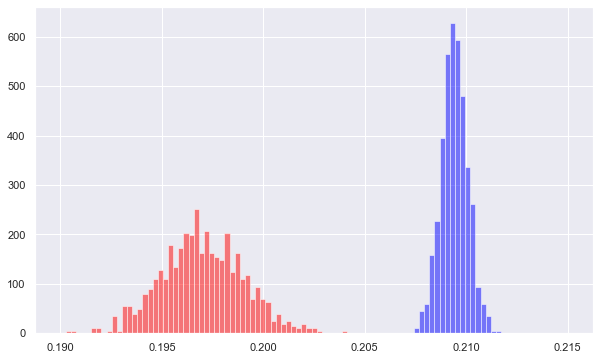

In [302]:
#these are the bootstrapped values
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x=b1, color=(0,0,1,.5), bins=np.linspace(0.19,0.215,100), density=True, alpha=0.5)
ax.hist(x=b2, color=(1,0,0,.5), bins=np.linspace(0.19,0.215,100), density=True, alpha=0.5);

Finally, show the bootstrapped estimates of the % difference in means log(m1 / m2). 

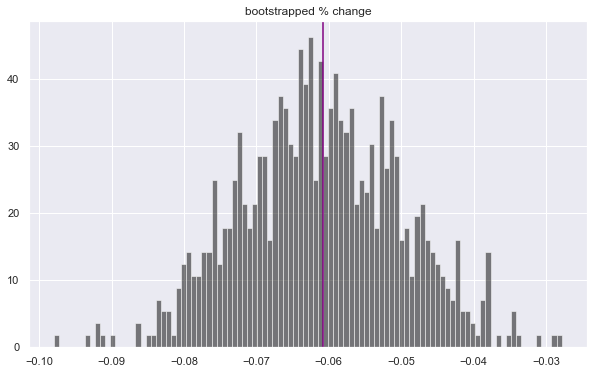

In [299]:
# log(b2/b1) is a vector containing the percent change in each bootstrap iteration
# plot its histogram
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(np.log(b2/b1), color='black', bins=100, density=True, alpha=0.5)
ax.axvline(np.log(m2/m1), color="purple")
ax.set_title('bootstrapped % change');

Alternatively, we could show the bootstrapped estimate of the actual difference in means (m1 - m2)

## Permutation tests

Test the H0 that the distributions are identical

### Part 1: Generate fake data
Identical to part 1 above: use the same data even!

### Part 2: Generate bootstrapped samples
For each data point i, draw nbootstrapped draws from a multinomial distribution with probabilities proportional to the group sizes

In [3]:
from sklearn.utils import resample
nbootstraps = 800

In [37]:
# draw permuted samples: ideally should be sampling without replacement, but at scale, that's not feasible
samplecounts = pd.Series(['b1', 'b2']).sample(nbootstraps*n, replace=True, weights=[n1,n2]).to_numpy()

In [38]:
samplecounts = samplecounts.reshape((n,-1))

For example, the first data point gets assigned to the following groups in each of 800 samples:

In [40]:
samplecounts[0]

array(['b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b2', 'b1',
       'b2', 'b1', 'b1', 'b1', 'b2', 'b1', 'b1', 'b2', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b2', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b2', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b2', 'b1', 'b1',
       'b1', 'b1', 'b2', 'b2', 'b2', 'b1', 'b2', 'b1', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b2', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b2', 'b1', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1',
       'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b1', 'b2', 'b1', 'b1', 'b1',
       'b1', 'b2', 'b1', 'b2', 'b2', 'b1', 'b1', 'b

### Part 3: Write the function that does the parallelized computation
Identical function as part 3 above 

### Part 4: Compute distribution of the statistic under H0
Compute permuted means per group.

In [47]:
# compute our statistic (diff in means)
b1 = group_bootstrapped_mean(input_data['x'], (samplecounts=='b1').astype(np.int8))
b2 = group_bootstrapped_mean(input_data['x'], (samplecounts=='b2').astype(np.int8))

Although we don't need to show this, let's check the distribution of the permuted means:

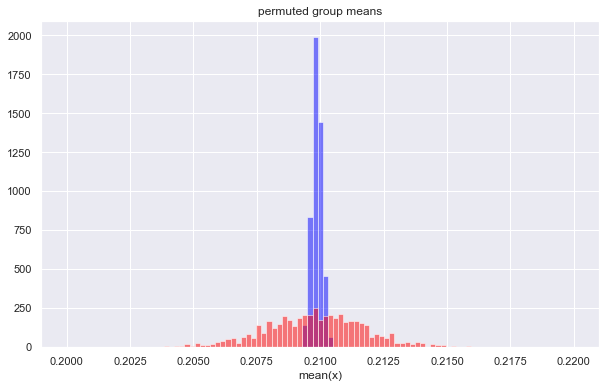

In [54]:
# these are the permuted values under the null
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x=b1, color=(0,0,1,.5), bins=np.linspace(0.20,0.22,100), density=True, alpha=0.5)
ax.hist(x=b2, color=(1,0,0,.5), bins=np.linspace(0.20,0.22,100), density=True, alpha=0.5)
ax.set_xlabel('mean(x)');
ax.set_title('permuted group means');

Plot the distribution of the test statistic under the null, and the actual statistic (vertical line)

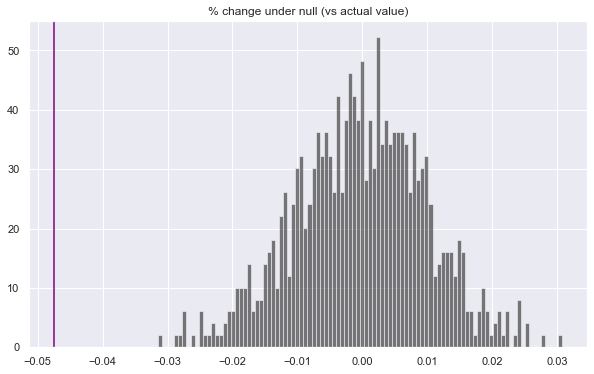

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(np.log(b2/b1), color='black', bins=100, density=True, alpha=0.5)
ax.axvline(np.log(m2/m1), color="purple")
ax.set_title('% change under null (vs actual value)');